In [1]:
import tulip as tlp
from tulip.interfaces import omega as omega_int
from tulip import transys, abstract, spec, synth
from visualization import graph_builder as gb
import networkx as nx
from tulip.transys import machines
from GR1_defaults import settings

from tulip import dumpsmach
import pickle

from omega.games import enumeration as enum

`omega.symbolic.symbolic` failed to import `dd.cudd`.
Will use `dd.autoref`.
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/mathset.py:719: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/mathset.py:719: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/labeled_graphs.py:1218: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/labeled_graphs.py:1226: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/labeled_graphs.py:1218: SyntaxWarning: "is" with a literal

In [2]:
path = 'left_turn/'

In [3]:
# System definition
sys = tlp.transys.FTS()

sys.atomic_propositions.add_from({'a4', 'a7', 'a8', 'a9'})
sys.states.add('c4', ap={'a4'})
sys.states.add('c7', ap={'a7'})
sys.states.add('c8', ap={'a8'})
sys.states.add('c9', ap={'a9'})
sys.states.initial.add('c7')    # start in state c7

sys.transitions.add_comb({'c7'}, {'c7', 'c8'})
sys.transitions.add_comb({'c8'}, {'c8', 'c4'})
sys.transitions.add_comb({'c4'}, {'c4', 'c9'})
sys.transitions.add_comb({'c9'}, {'c9'})

In [4]:
# Variables
env_vars = {'vh': (2, 6), 
            'light': ["g1", "g2", "g3", "y1", "y2", "r"]}
sys_vars = {}

In [5]:
# Initialization
env_init = {'vh = 2',
            'light = "g1"'}
sys_init = {}

In [6]:
# Safety
env_safe = {
    # Human vehicle movement
    'vh = 2 -> next(vh) = 2 | next(vh) = 3',
    'vh = 3 -> next(vh) = 3 | next(vh) = 4',
    'vh = 4 -> next(vh) = 4 | next(vh) = 5',
    'vh = 5 -> next(vh) = 5 | next(vh) = 6',
    'vh = 6 -> next(vh) = 6',
    # Traffic light
    'light = "g1" -> next(light = "g2")',
    'light = "g2" -> next(light = "g3")',
    'light = "g3" -> next(light = "y1")',
    'light = "y1" -> next(light = "y2")',
    'light = "y2" -> next(light = "r")',
    'light = "r" -> next(light = "r") | next(light = "g1")',
    # Human vehicle does not run a red
    '!(light = "r" & (vh = 4 | vh = 5))'
}
sys_safe = {
    # No collision with human vehicle
    '!(a4 & vh = 4)',
    # No running a red
    '!(light="r" & (a4 || a8))' #,
    # No being collided into by the human vehicle
    # Commenting this out means that we are considering the game as having simultaneous updates
    # '!(a4 & X(vh = 4))'
}

In [7]:
# Progress
env_prog = {'vh = 6',
            'light = "g1"'}
sys_prog = {'a9'}
    

specs = settings.set_specs(env_vars, sys_vars, env_init, sys_init,
                        env_safe, sys_safe, env_prog, sys_prog)
print(specs.pretty())

spec = tlp.synth._spec_plus_sys(specs, None, sys, False, False)
# Automaton class found in omega/omega/symbolic/temporal.py
aut = omega_int._grspec_to_automaton(spec)

ENVIRONMENT VARIABLES:
	vh	(2, 6)
	light	['g1', 'g2', 'g3', 'y1', 'y2', 'r']

SYSTEM VARIABLES:
	(none)

FORMULA:
ASSUMPTION:
    INITIAL
	  (light = "g1")
	& (vh = 2)
    SAFETY
	  [](!(light = "r" & (vh = 4 | vh = 5)))
	& [](light = "g1" -> next(light = "g2"))
	& [](light = "g2" -> next(light = "g3"))
	& [](light = "g3" -> next(light = "y1"))
	& [](light = "y1" -> next(light = "y2"))
	& [](vh = 4 -> next(vh) = 4 | next(vh) = 5)
	& [](vh = 2 -> next(vh) = 2 | next(vh) = 3)
	& [](light = "r" -> next(light = "r") | next(light = "g1"))
	& [](vh = 6 -> next(vh) = 6)
	& [](vh = 5 -> next(vh) = 5 | next(vh) = 6)
	& [](vh = 3 -> next(vh) = 3 | next(vh) = 4)
	& [](light = "y2" -> next(light = "r"))
    LIVENESS
	  []<>(light = "g1")
	& []<>(vh = 6)
GUARANTEE:
    SAFETY
	  [](!(light="r" & (a4 || a8)))
	& [](!(a4 & vh = 4))
    LIVENESS
	  []<>(a9)



In [8]:
# Synthesize the controller
ctrl = tlp.synth.synthesize(specs, sys=sys)
assert ctrl is not None, 'unrealizable'
with open(path + "ctrl", "wb") as file:
    pickle.dump(ctrl, file)

dumpsmach.write_python_case(path + 'controller.py', ctrl, classname="sys_ctrl")

removed 6 nodes from 47 total


/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/export/graph2dot.py:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/export/graph2dot.py:111: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/export/graph2dot.py:112: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/export/graph2dot.py:155: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/export/graph2dot.py:157: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech

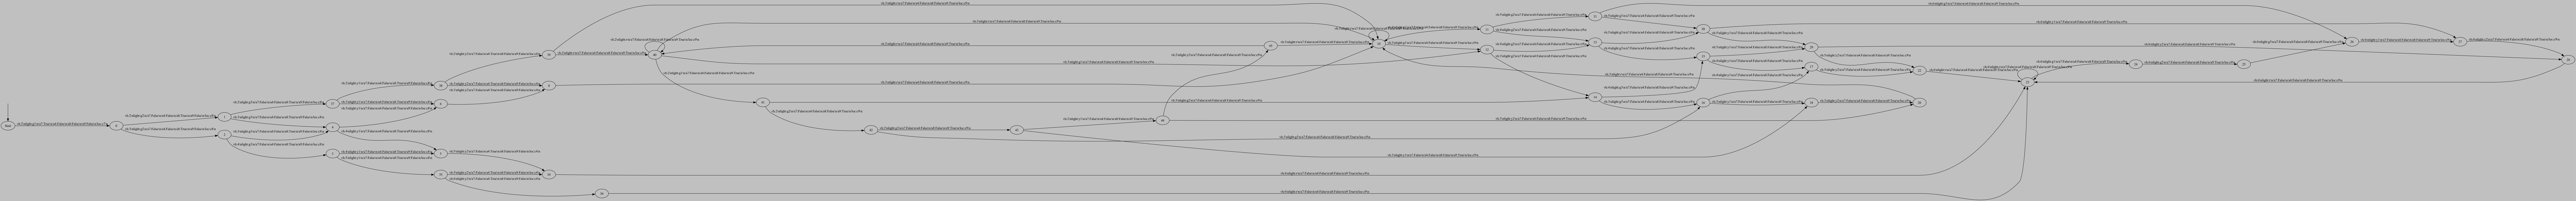

True

In [9]:
ctrl.plot()

In [10]:
# spec = tlp.synth._spec_plus_sys(specs, None, sys, False, False)
# # Automaton class found in omega/omega/symbolic/temporal.py
# aut = omega_int._grspec_to_automaton(specs)

In [11]:
enum.action_to_steps(aut, env='env', sys='sys',qinit=aut.qinit)

AssertionError: 

In [18]:
enum.action_to_steps(aut, env='env', sys='sys')

AssertionError: 

In [19]:
enum.action_to_steps(aut, env='env', sys='impl')

KeyError: 'impl'

In [ ]:
# Graphing
filename = path + "graph"
attributes = ['color', 'shape']

# Making a graph of the asynchronous GR(1) game with deadends.
g0 = gb.game_graph(aut, env='env', sys='sys', remove_deadends=False, append_non_visited=False, qinit=aut.qinit)
h0 = gb._game_format_nx(g0, attributes)
pd0 = nx.drawing.nx_pydot.to_pydot(h0)
pd0.write_pdf(path + 'game.pdf')
with open(filename, "wb") as file:
    pickle.dump(g0, file)

about to create game graph
found winning set
before queue
